In [ ]:
import pandas as pd
import dask.dataframe as dd
import dask
import numpy as np
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from glob import glob
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import tqdm
import pickle

gc.collect()

20

In [2]:
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'
test_path = '/home/stargix/Desktop/hackathons/datathon/test/test'

In [ ]:
# Definir columnas necesarias
required_columns = [
    'row_id', 'datetime',
    'buyer_d7', 'iap_revenue_d7',
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 
    'advertiser_bottom_taxonomy_level',
    'country', 'region',
    'dev_make', 'dev_model', 'dev_os', 'dev_osv',
    'carrier',
    'hour', 'weekday', 'weekend_ratio', 'hour_ratio',
    'release_date', 'release_msrp',
    'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration',
    'weeks_since_first_seen', 'wifi_ratio',
    'retentiond7',
    'city_hist', 'country_hist', 'region_hist', 'dev_language_hist', 'dev_osv_hist',
    'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk',
    'iap_revenue_usd_bundle', 'iap_revenue_usd_category',
    'num_buys_bundle', 'num_buys_category',
    'last_buy', 'last_ins',
    'bcat', 'bcat_bottom_taxonomy',
    'bundles_cat', 'bundles_cat_bottom_taxonomy', 
    'bundles_ins',
    'new_bundles', 'user_bundles', 'user_bundles_l28d',
    'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_count', 'user_actions_bundles_action_last_timestamp',
    'last_advertiser_action',
    'first_request_ts', 'first_request_ts_bundle', 
    'first_request_ts_category_bottom_taxonomy',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank'
]

# Obtener todos los archivos parquet para procesar por batches
parquet_files_train = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
print(f"Total archivos disponibles: {len(parquet_files_train)}")

# Dividir en batches del 10%
batch_size = max(1, int(len(parquet_files_train) * 0.1))
num_batches = (len(parquet_files_train) + batch_size - 1) // batch_size
print(f"Batch size: {batch_size} archivos")
print(f"Número de batches: {num_batches}")

✓ Train cargado con 14 archivos


In [ ]:
# Función para preprocesar columnas con listas
import ast

columns_to_sum = [
    'iap_revenue_usd_bundle',
    'num_buys_bundle',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank',
    'whale_users_bundle_revenue_prank'
]

def sum_values(x):
    """Suma todos los valores numéricos de la lista"""
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return 0
    try:
        if isinstance(x, str):
            x = ast.literal_eval(x)
        
        if isinstance(x, list) and len(x) > 0:
            total = sum([item[1] for item in x if isinstance(item, tuple) and len(item) > 1])
            return total
        return 0
    except:
        return 0

def preprocess_dataframe(df, label_encoders=None, fit_encoders=False):
    """Preprocesa un DataFrame con transformaciones de listas y label encoding"""
    
    # Sumar columnas con listas
    for col in columns_to_sum:
        if col in df.columns:
            df[col] = df[col].apply(sum_values)
    
    # Label encoding
    cat_features = [
        'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory',
        'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv'
    ]
    cat_features = [c for c in cat_features if c in df.columns]
    
    if fit_encoders:
        label_encoders = {}
        for col in cat_features:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str).fillna("__NA__"))
            label_encoders[col] = le
    else:
        for col in cat_features:
            if col in label_encoders:
                df[col] = df[col].astype(str).fillna("__NA__")
                df[col] = df[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)
    
    return df, label_encoders, cat_features

print("✓ Función de preprocesamiento definida")

PREPROCESANDO COLUMNAS CON LISTAS

📊 Procesando iap_revenue_usd_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=744884.6500, mean=4.4307

📊 Procesando num_buys_bundle...
  ✓ Convertido a numérico
  Tipo nuevo: int64
  Valores ejemplo: [0 0 0]
  Stats: min=0.0000, max=4127.0000, mean=0.5360

📊 Procesando rwd_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=14.4057, mean=0.6217

📊 Procesando whale_users_bundle_num_buys_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=0.0000, max=17.3464, mean=0.0157

📊 Procesando whale_users_bundle_revenue_prank...
  ✓ Convertido a numérico
  Tipo nuevo: float64
  Valores ejemplo: [0. 0. 0.]
  Stats: min=-0.0208, max=6.4125, mean=0.0055

✓ PREPROCESAMIENTO COMPLETADO


In [ ]:
# Cargar primer batch para definir features y fitear scaler
print("=" * 60)
print("CARGANDO PRIMER BATCH PARA CONFIGURACIÓN")
print("=" * 60)

first_batch_files = parquet_files_train[:batch_size]
try:
    first_ddf = dd.read_parquet(first_batch_files, engine='pyarrow', columns=required_columns)
except Exception as e:
    print(f"⚠️ Cargando todas las columnas: {e}")
    first_ddf = dd.read_parquet(first_batch_files, engine='pyarrow')

first_df = first_ddf.compute(scheduler='synchronous')
print(f"✓ Primer batch cargado: {first_df.shape}")

# Preprocesar primer batch y definir encoders
first_df, label_encoders, cat_features = preprocess_dataframe(first_df, fit_encoders=True)

# Definir features
labels_to_exclude = [
    'buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28',
    'buy_d7', 'buy_d14', 'buy_d28',
    'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28',
    'registration', 'retention_d1_to_d7', 'retention_d3_to_d7',
    'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retention_d7',
    'row_id', 'datetime',
    'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_last_timestamp',
    'first_request_ts', 'first_request_ts_bundle',
    'first_request_ts_category_bottom_taxonomy'
]

numeric_features = [
    c for c in first_df.columns
    if c not in labels_to_exclude and c not in cat_features
    and first_df[c].dtype in ['int64', 'int32', 'int16', 'int8', 'float32', 'float64']
]

features = numeric_features + cat_features
print(f"✓ Features definidas: {len(features)} ({len(numeric_features)} numéricas + {len(cat_features)} categóricas)")

# Crear y fitear StandardScaler con primer batch
scaler = StandardScaler()
first_df[numeric_features] = first_df[numeric_features].fillna(0)
scaler.fit(first_df[numeric_features])
print(f"✓ StandardScaler fiteado con {len(first_df)} muestras")

# Guardar scaler y encoders
with open('/home/stargix/Desktop/hackathons/datathon/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('/home/stargix/Desktop/hackathons/datathon/label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("✓ Scaler y encoders guardados")

del first_df, first_ddf
gc.collect()

Total features: 24


In [ ]:
# ENTRENAMIENTO POR BATCHES
print("\n" + "=" * 60)
print("ENTRENAMIENTO POR BATCHES (10% cada vez)")
print("=" * 60)

# Parámetros del modelo
params_optimized = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 127,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

# Inicializar modelo
model = None
validation_date = pd.Timestamp('2025-10-06', tz='UTC')

# Procesar cada batch
for batch_idx in range(num_batches):
    print(f"\n{'='*60}")
    print(f"BATCH {batch_idx + 1}/{num_batches}")
    print(f"{'='*60}")
    
    # Seleccionar archivos del batch
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(parquet_files_train))
    batch_files = parquet_files_train[start_idx:end_idx]
    
    # Cargar batch
    try:
        batch_ddf = dd.read_parquet(batch_files, engine='pyarrow', columns=required_columns)
    except:
        batch_ddf = dd.read_parquet(batch_files, engine='pyarrow')
    
    batch_df = batch_ddf.compute(scheduler='synchronous')
    print(f"✓ Batch cargado: {batch_df.shape}")
    
    # Preprocesar
    batch_df, _, _ = preprocess_dataframe(batch_df, label_encoders=label_encoders, fit_encoders=False)
    
    # Split temporal
    batch_df['datetime'] = pd.to_datetime(batch_df['datetime'].astype(str))
    val_mask = batch_df['datetime'].dt.date == validation_date.date()
    
    train_mask = ~val_mask
    if train_mask.sum() == 0:
        print("⚠️ No hay datos de entrenamiento en este batch, saltando...")
        del batch_df, batch_ddf
        gc.collect()
        continue
    
    X_train_batch = batch_df[train_mask][features].copy()
    y_train_batch = batch_df[train_mask]['iap_revenue_d7'].copy()
    
    # Aplicar StandardScaler a features numéricas
    X_train_batch[numeric_features] = X_train_batch[numeric_features].fillna(0)
    X_train_batch[numeric_features] = scaler.transform(X_train_batch[numeric_features])
    
    # Convertir categóricas
    for col in cat_features:
        if col in X_train_batch.columns:
            X_train_batch[col] = X_train_batch[col].astype('category')
    
    # Transform target con log1p
    y_train_log = np.log1p(y_train_batch)
    
    # Entrenar o continuar entrenamiento
    cat_features_valid = [col for col in cat_features if col in features]
    train_ds = lgb.Dataset(X_train_batch, label=y_train_log, categorical_feature=cat_features_valid)
    
    if model is None:
        # Primera iteración: crear modelo
        print(f"Entrenando modelo inicial con {len(X_train_batch):,} muestras...")
        model = lgb.train(
            params_optimized,
            train_ds,
            num_boost_round=200,
            valid_sets=[train_ds]
        )
    else:
        # Continuar entrenamiento
        print(f"Continuando entrenamiento con {len(X_train_batch):,} muestras...")
        model = lgb.train(
            params_optimized,
            train_ds,
            num_boost_round=200,
            init_model=model,
            valid_sets=[train_ds]
        )
    
    print(f"✓ Batch {batch_idx + 1} procesado ({model.num_trees()} árboles totales)")
    
    # Limpiar memoria
    del batch_df, batch_ddf, X_train_batch, y_train_batch, y_train_log, train_ds
    gc.collect()

print("\n" + "=" * 60)
print("✓ ENTRENAMIENTO COMPLETADO")
print(f"Total de árboles: {model.num_trees()}")
print("=" * 60)

/tmp/ipykernel_177671/2954038451.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))


Fecha máxima dataset: 2025-10-06 13:00:00+00:00
Fecha validación: 2025-10-06
Train: 1,946,875 samples (2025-10-01 05:00:00+00:00 a 2025-10-05 13:00:00+00:00)
Val: 157,391 samples (2025-10-06 13:00:00+00:00 a 2025-10-06 13:00:00+00:00)
Val es solo día 2025-10-06: True


In [ ]:
# EVALUACIÓN EN CONJUNTO DE VALIDACIÓN
print("\n" + "=" * 60)
print("EVALUACIÓN EN VALIDACIÓN")
print("=" * 60)

# Cargar datos de validación (solo día 2025-10-06)
val_data = []
for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, len(parquet_files_train))
    batch_files = parquet_files_train[start_idx:end_idx]
    
    try:
        batch_ddf = dd.read_parquet(batch_files, engine='pyarrow', columns=required_columns)
    except:
        batch_ddf = dd.read_parquet(batch_files, engine='pyarrow')
    
    batch_df = batch_ddf.compute(scheduler='synchronous')
    batch_df, _, _ = preprocess_dataframe(batch_df, label_encoders=label_encoders, fit_encoders=False)
    
    batch_df['datetime'] = pd.to_datetime(batch_df['datetime'].astype(str))
    val_mask = batch_df['datetime'].dt.date == validation_date.date()
    
    if val_mask.sum() > 0:
        val_data.append(batch_df[val_mask])
    
    del batch_df, batch_ddf
    gc.collect()

# Combinar todos los datos de validación
val_df = pd.concat(val_data, ignore_index=True)
print(f"✓ Datos de validación: {len(val_df):,} muestras")

X_val = val_df[features].copy()
y_val = val_df['iap_revenue_d7'].copy()

# Aplicar StandardScaler
X_val[numeric_features] = X_val[numeric_features].fillna(0)
X_val[numeric_features] = scaler.transform(X_val[numeric_features])

# Convertir categóricas
for col in cat_features:
    if col in X_val.columns:
        X_val[col] = X_val[col].astype('category')

# Predecir
from time import time
start_time = time()
pred_log = model.predict(X_val)
pred = np.expm1(pred_log).clip(0, None)
end_time = time()
elapsed_time = end_time - start_time

# Métricas
msle = mean_squared_log_error(y_val, pred)
rmse = mean_squared_error(y_val, pred, squared=False)

print("=" * 60)
print("RESULTADOS EN VALIDACIÓN")
print("=" * 60)
print(f"Tiempo de predicción: {elapsed_time:.2f} segundos")
print(f"MSLE: {msle:.6f}")
print(f"RMSE: ${rmse:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print("=" * 60)

del val_df, val_data, X_val, y_val, pred_log, pred
gc.collect()

✓ Datos preprocesados


In [ ]:
# Guardar modelo entrenado
model.save_model('/home/stargix/Desktop/hackathons/datathon/lgbm_batch_model.txt')
print("✓ Modelo guardado en: lgbm_batch_model.txt")

ENTRENANDO MODELO OPTIMIZADO
Parámetros:
  Learning rate: 0.01
  Num leaves: 127
  Max depth: -1
  Min data in leaf: 20


In [ ]:
"""# GRID SEARCH PARA OPTIMIZAR HIPERPARÁMETROS
from sklearn.model_selection import ParameterGrid
import time

print("=" * 60)
print("GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS")
print("=" * 60)

# Definir grid de parámetros
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 10, 15],
    'min_data_in_leaf': [20, 50, 100],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9]
}

# Base params
base_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

# Preparar datasets
cat_features_valid = [col for col in cat_features if col in features]
train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

# Grid search
results = []
best_score = float('inf')
best_params = None

grid = list(ParameterGrid(param_grid))
print(f"\nTotal combinaciones a probar: {len(grid)}")
print("Probando combinaciones (esto puede tardar)...\n")

for i, params in enumerate(grid[:20], 1):  # Limitar a 20 combinaciones para no tardar mucho
    print(f"[{i}/20] Probando: lr={params['learning_rate']}, leaves={params['num_leaves']}, depth={params['max_depth']}")
    
    # Combinar params
    current_params = {**base_params, **params}
    
    # Entrenar
    start_time = time.time()
    model_temp = lgb.train(
        current_params,
        train_ds,
        num_boost_round=500,  # Reducido para grid search
        valid_sets=[val_ds],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    elapsed = time.time() - start_time
    
    # Evaluar
    pred_log = model_temp.predict(X_val)
    pred = np.expm1(pred_log).clip(0, None)
    msle = mean_squared_log_error(y_val, pred)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    
    # Guardar resultado
    results.append({
        **params,
        'msle': msle,
        'rmse': rmse,
        'best_iteration': model_temp.best_iteration,
        'time': elapsed
    })
    
    print(f"  ✓ MSLE: {msle:.6f} | RMSE: {rmse:.2f} | Iters: {model_temp.best_iteration} | Time: {elapsed:.1f}s")
    
    # Actualizar mejor
    if msle < best_score:
        best_score = msle
        best_params = params
        print(f"  🎯 NUEVO MEJOR SCORE!")
    
    print()

# Mostrar resultados
print("=" * 60)
print("RESULTADOS GRID SEARCH")
print("=" * 60)

results_df = pd.DataFrame(results).sort_values('msle')
print("\nTop 5 mejores combinaciones:")
print(results_df.head(10).to_string(index=False))

print("\n" + "=" * 60)
print("MEJORES PARÁMETROS ENCONTRADOS:")
print("=" * 60)
for key, value in best_params.items():
    print(f"  {key}: {value}")
print(f"\nMejor MSLE: {best_score:.6f}")
print("=" * 60)

# Entrenar modelo final con mejores params
print("\nEntrenando modelo final con mejores parámetros...")
final_params = {**base_params, **best_params}

model_final = lgb.train(
    final_params,
    train_ds,
    num_boost_round=2000,
    valid_sets=[train_ds, val_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print(f"✓ Modelo final entrenado ({model_final.best_iteration} iteraciones)")

# Evaluar modelo final
pred_log = model_final.predict(X_val)
pred = np.expm1(pred_log).clip(0, None)
msle_final = mean_squared_log_error(y_val, pred)
rmse_final = np.sqrt(mean_squared_error(y_val, pred))

print("\n" + "=" * 60)
print("RESULTADOS FINALES CON MEJORES PARÁMETROS")
print("=" * 60)
print(f"MSLE: {msle_final:.6f}")
print(f"RMSE: ${rmse_final:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print("=" * 60)

# Guardar modelo final
model = model_final"""

'# GRID SEARCH PARA OPTIMIZAR HIPERPARÁMETROS\nfrom sklearn.model_selection import ParameterGrid\nimport time\n\nprint("=" * 60)\nprint("GRID SEARCH - OPTIMIZACIÓN DE HIPERPARÁMETROS")\nprint("=" * 60)\n\n# Definir grid de parámetros\nparam_grid = {\n    \'learning_rate\': [0.01, 0.03, 0.05],\n    \'num_leaves\': [31, 63, 127],\n    \'max_depth\': [-1, 10, 15],\n    \'min_data_in_leaf\': [20, 50, 100],\n    \'feature_fraction\': [0.7, 0.8, 0.9],\n    \'bagging_fraction\': [0.7, 0.8, 0.9]\n}\n\n# Base params\nbase_params = {\n    \'objective\': \'regression\',\n    \'metric\': \'rmse\',\n    \'bagging_freq\': 5,\n    \'verbose\': -1,\n    \'device\': \'cpu\'\n}\n\n# Preparar datasets\ncat_features_valid = [col for col in cat_features if col in features]\ntrain_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)\nval_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)\n\n# Grid search\nresults = []\nbest_score = float(\'inf\')\nbest_params = None

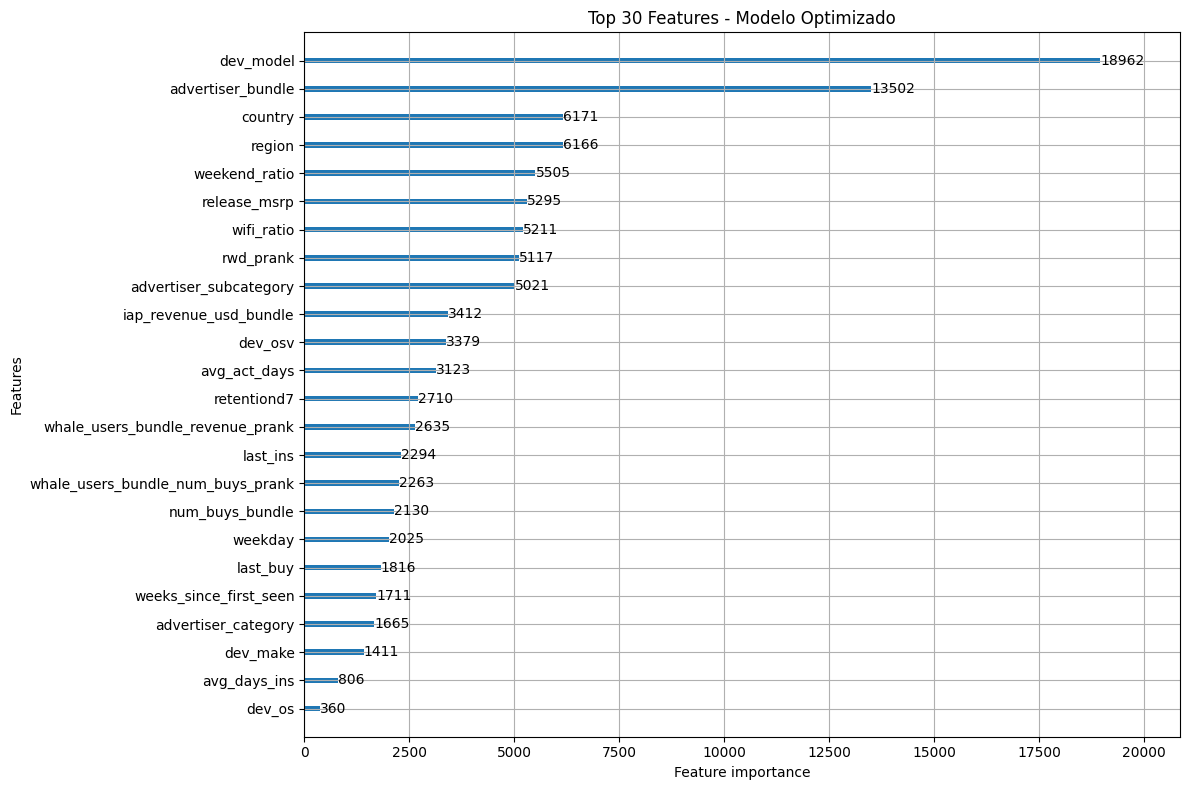

In [ ]:
# Feature importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=30, ax=ax, title='Top 30 Features - Modelo con Batch Training')
plt.tight_layout()
plt.show()

In [ ]:
# INFERENCIA OPTIMIZADA EN TEST
import time

TEST_PATH = "/home/stargix/Desktop/hackathons/datathon/test/test"

print("=" * 60)
print("GENERANDO PREDICCIONES EN TEST (OPTIMIZADO CON SCALER)")
print("=" * 60)

# Cargar scaler y encoders
with open('/home/stargix/Desktop/hackathons/datathon/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('/home/stargix/Desktop/hackathons/datathon/label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

# Repartir parquet en bloques pequeños
test_meta = dd.read_parquet(TEST_PATH, engine="pyarrow", index=False).head(0)
available_cols = [c for c in ["row_id"] + features if c in test_meta.columns]

dd_test = dd.read_parquet(
    TEST_PATH,
    engine="pyarrow",
    columns=available_cols,
    blocksize="128MB"
)
dd_test = dd_test.repartition(npartitions=384)
delayed_parts = dd_test.to_delayed()
print(f"Chunks repartidos: {len(delayed_parts)}\n")

# Preparar mapeos de label encoders
le_maps = {
    col: {cls: idx for idx, cls in enumerate(enc.classes_)}
    for col, enc in label_encoders.items()
}

def sum_list_series(series: pd.Series) -> pd.Series:
    """Suma valores de listas de forma vectorizada"""
    return series.apply(
        lambda x: sum(item[1] for item in x if isinstance(item, tuple) and len(item) > 1)
        if isinstance(x, list) else 0
    )

pred_dfs = []

for i, delayed_part in enumerate(delayed_parts, 1):
    t0 = time.perf_counter()
    part_df = delayed_part.compute()
    row_ids = part_df["row_id"].values

    # Preparar features
    X_part = part_df.reindex(columns=features, fill_value=0)

    # Sumar columnas con listas
    for col in columns_to_sum:
        if col in X_part.columns:
            X_part[col] = sum_list_series(X_part[col])

    # Procesar numéricas
    if numeric_features:
        X_part[numeric_features] = X_part[numeric_features].apply(pd.to_numeric, errors="coerce")
        X_part[numeric_features] = X_part[numeric_features].fillna(0)
        # Aplicar StandardScaler
        X_part[numeric_features] = scaler.transform(X_part[numeric_features])

    # Procesar categóricas con label encoding
    cat_dtypes = {
        col: pd.CategoricalDtype(categories=range(len(enc.classes_)))
        for col, enc in label_encoders.items()
    }

    for col in cat_features:
        if col in X_part.columns:
            mapped = (
                X_part[col].astype(str)
                .map(le_maps[col])
                .fillna(-1)
                .astype("int16")
            )
            X_part[col] = pd.Categorical(mapped, dtype=cat_dtypes[col])

    # Predecir (rápido con modelo optimizado)
    pred_log = model.predict(X_part, num_iteration=model.best_iteration)
    pred = np.expm1(pred_log).clip(0, None)

    pred_dfs.append(pd.DataFrame({"row_id": row_ids, "iap_revenue_d7": pred}))

    elapsed = time.perf_counter() - t0
    print(f"[{i}/{len(delayed_parts)}] {len(row_ids):,} filas | {elapsed:.2f}s")
    
    del part_df, X_part, pred_log, pred, row_ids
    gc.collect()

print("=" * 60)
print("FINALIZANDO SUBMISSION")
print("=" * 60)

submission = pd.concat(pred_dfs, ignore_index=True)

print(f"Total filas: {len(submission):,}")
print(f"Row IDs únicos: {submission['row_id'].nunique():,}")
print(f"Duplicados: {submission['row_id'].duplicated().sum()}")
print(f"NaNs: {submission['iap_revenue_d7'].isna().sum()}")
print("\nEstadísticas predicciones:")
print(submission['iap_revenue_d7'].describe())

submission_path = "/home/stargix/Desktop/hackathons/datathon/submission_optimized_scaler.csv"
submission.to_csv(submission_path, index=False)
print(f"\n✓ Guardado en: {submission_path}")
print("=" * 60)

submission.head(10)

GENERANDO PREDICCIONES EN TEST (OPTIMIZADO)
Chunks repartidos: 384

[1/384] 29,611 filas | 0.8s
[2/384] 29,611 filas | 0.7s
[3/384] 29,612 filas | 0.7s
[4/384] 29,611 filas | 0.7s
[5/384] 29,612 filas | 0.9s
[6/384] 29,611 filas | 0.9s
[7/384] 29,611 filas | 0.7s
[8/384] 29,612 filas | 0.7s
[9/384] 29,611 filas | 0.7s
[10/384] 29,612 filas | 0.7s
[11/384] 29,611 filas | 0.7s
[12/384] 29,612 filas | 0.7s
[13/384] 30,211 filas | 0.7s
[14/384] 30,212 filas | 0.7s
[15/384] 30,212 filas | 0.7s
[16/384] 30,212 filas | 0.7s
[17/384] 30,212 filas | 0.7s
[18/384] 30,212 filas | 0.7s
[19/384] 30,212 filas | 0.7s
[20/384] 30,212 filas | 0.7s
[21/384] 30,212 filas | 0.7s
[22/384] 30,212 filas | 0.7s
[23/384] 30,212 filas | 0.7s
[24/384] 30,212 filas | 0.8s
[25/384] 30,453 filas | 0.8s
[26/384] 30,454 filas | 0.7s
[27/384] 30,454 filas | 0.7s
[28/384] 30,454 filas | 0.7s
[29/384] 30,454 filas | 0.7s
[30/384] 30,454 filas | 0.7s
[31/384] 30,453 filas | 0.7s
[32/384] 30,454 filas | 0.8s
[33/384] 30,4

,row_id,iap_revenue_d7
0,e2f514a9-d922-4a17-bf94-f228bf4cd82f,0.001260
1,4bfc70d3-d619-410a-9683-4cd759f30f32,0.007292
2,ad433b66-b41e-4157-a6fd-24cd30701f6a,0.000060
3,5ed964d6-ddce-42e8-9fad-276eb7f64c2f,0.007806
4,81b73a45-c395-4d08-a4a3-513873440db3,0.001695
5,22c09d3c-037d-4733-be84-764b0beea8ef,0.135365
6,c991d87f-acee-40f5-9159-c2b9edd3c3ed,0.021429
7,2ab1e530-3dd4-4a36-a33a-d9fe1b934b60,0.000000
8,21fcdadc-5c27-4e31-8edf-1d84f93517ef,0.002076
9,8131e176-c2fe-41b1-99da-771096ce48f1,0.000174
